# RNN Model Development

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_gbq

#from google.colab import drive 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from datetime import datetime, timedelta


## Google Colab <-> Drive Mouting

In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Importing full df

In [61]:
list_of_dfs = ["ban", "cummies", "dinu", "doge",
"doggy", "elon", "erc20", "ftm", "grlc", "hoge",
"lowb", "mona", "samo", "shib", "shibx", "smi",
"wow", "yooshi","yummy"]


project_id = 'crypto-prediction-333213'

dfs = []

for df in list_of_dfs:
    
    sql = f"""
    SELECT *
    FROM `crypto-prediction-333213.crypto_DB.{df}`;
    """
    
    dfs.append(pd.read_gbq(sql, project_id=project_id, dialect='standard'))
    
dfs

/Users/marten/.pyenv/versions/3.8.12/envs/crypto_prediction/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1967: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  df[column] = pandas.Series(df[column], dtype=dtypes[column])


[              timestamp_field_0  price_ban  trend_ban
 0     2021-09-29 12:00:00+00:00   0.007230        0.0
 1     2021-09-29 13:00:00+00:00   0.007224        0.0
 2     2021-09-29 14:00:00+00:00   0.007217        0.0
 3     2021-09-29 15:00:00+00:00   0.007233        0.0
 4     2021-09-29 16:00:00+00:00   0.007157        0.0
 ...                         ...        ...        ...
 10336 2021-11-27 00:00:00+00:00   0.014607       91.0
 10337 2021-10-07 22:00:00+00:00   0.008030       95.0
 10338 2021-10-29 21:00:00+00:00   0.023039       95.0
 10339 2021-10-29 23:00:00+00:00   0.025143       95.0
 10340 2021-11-10 23:00:00+00:00   0.022179       99.0
 
 [10341 rows x 3 columns],
               timestamp_field_0  price_cummies  trend_cummies
 0     2021-09-29 12:00:00+00:00       0.025811            0.0
 1     2021-09-29 13:00:00+00:00       0.025518            0.0
 2     2021-09-29 14:00:00+00:00       0.025216            0.0
 3     2021-09-29 15:00:00+00:00       0.024521            

In [132]:
list_of_dfs = ["ban", "cummies", "dinu", "doge",
"doggy", "elon", "ftm", "grlc", "hoge",
"lowb", "mona", "samo", "shib", "shibx", "smi",
"wow", "yooshi","yummy"]

In [107]:
# removed erc20 as it could not be retreived

list_of_dfs = ["ban", "cummies", "dinu", "doge",
"doggy", "elon", "ftm", "grlc", "hoge",
"lowb", "mona", "samo", "shib", "shibx", "smi",
"wow", "yooshi","yummy"]


project_id = 'crypto-prediction-333213'

dfs = []

for df in list_of_dfs:

    sql = f"""
    SELECT *
    FROM `crypto-prediction-333213.crypto_DB.{df}`;
    """

    dfs.append(pd.read_gbq(sql, project_id=project_id, dialect='standard'))

dfs

/Users/marten/.pyenv/versions/3.8.12/envs/crypto_prediction/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1967: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  df[column] = pandas.Series(df[column], dtype=dtypes[column])


[             timestamp_field_0  price_ban  trend_ban  hourly_pct_change  \
 0    2021-10-11 08:00:00+00:00   0.008134        9.0           0.166991   
 1    2021-10-13 07:00:00+00:00   0.008061       10.0          -0.009014   
 2    2021-10-15 07:00:00+00:00   0.008762       10.0           0.087007   
 3    2021-10-18 09:00:00+00:00   0.006670       14.0           0.013584   
 4    2021-10-19 08:00:00+00:00   0.009668       14.0           0.449467   
 ...                        ...        ...        ...                ...   
 1356 2021-10-05 21:00:00+00:00   0.007190       91.0          -0.559335   
 1357 2021-10-07 21:00:00+00:00   0.008002       91.0           0.112880   
 1358 2021-10-27 22:00:00+00:00   0.007220       91.0          -0.097703   
 1359 2021-10-29 23:00:00+00:00   0.025143       95.0           0.091322   
 1360 2021-11-10 23:00:00+00:00   0.022179       99.0          -0.117884   
 
       MA12_hours  MA72_hours  MAshort_over_long  
 0       0.006914    0.007172      

In [81]:
for df in dfs:
    print(df.shape)

(1361, 7)
(1361, 7)
(1361, 7)
(1361, 7)
(1361, 7)
(1361, 7)
(1361, 7)
(1361, 7)
(1361, 7)
(1361, 7)
(1361, 7)
(1361, 7)
(1361, 7)
(1361, 7)
(1361, 7)
(1361, 7)
(1361, 7)
(1361, 7)


In [96]:
dfs[0]

,timestamp_field_0,price_ban,trend_ban,hourly_pct_change,MA12_hours,MA72_hours,MAshort_over_long,crypto_name
0,2021-10-11 08:00:00+00:00,0.008134,9.0,0.166991,0.006914,0.007172,0,ban
1,2021-10-13 07:00:00+00:00,0.008061,10.0,-0.009014,0.007018,0.007181,0,ban
2,2021-10-15 07:00:00+00:00,0.008762,10.0,0.087007,0.007182,0.007203,0,ban
3,2021-10-18 09:00:00+00:00,0.006670,14.0,0.013584,0.009047,0.009600,0,ban
4,2021-10-19 08:00:00+00:00,0.009668,14.0,0.449467,0.008603,0.009633,0,ban
...,...,...,...,...,...,...,...,...
1356,2021-10-05 21:00:00+00:00,0.007190,91.0,-0.559335,0.019141,0.016375,1,ban
1357,2021-10-07 21:00:00+00:00,0.008002,91.0,0.112880,0.017823,0.016374,1,ban
1358,2021-10-27 22:00:00+00:00,0.007220,91.0,-0.097703,0.016647,0.016358,1,ban
1359,2021-10-29 23:00:00+00:00,0.025143,95.0,0.091322,0.016417,0.016392,1,ban


# Combining dfs

In [108]:
#create col w crypto_name for each df
for i in range(len(dfs)):
    dfs[i]['crypto_name'] = dfs[i].columns[1][6:]
dfs[11]

,timestamp_field_0,price_samo,trend_samo,hourly_pct_change,MA12_hours,MA72_hours,MAshort_over_long,crypto_name
0,2021-10-17 06:00:00+00:00,0.013152,0.0,0.000214,0.013579,0.013714,0,samo
1,2021-10-17 07:00:00+00:00,0.013176,0.0,0.001793,0.013475,0.013730,0,samo
2,2021-10-17 08:00:00+00:00,0.013223,0.0,0.003575,0.013400,0.013740,0,samo
3,2021-10-17 09:00:00+00:00,0.013207,0.0,-0.001243,0.013353,0.013738,0,samo
4,2021-10-17 10:00:00+00:00,0.013093,0.0,-0.008619,0.013306,0.013733,0,samo
...,...,...,...,...,...,...,...,...
1356,2021-10-15 21:00:00+00:00,0.014205,87.0,-0.802502,0.114905,0.094174,1,samo
1357,2021-11-12 06:00:00+00:00,0.138185,87.0,8.728110,0.114457,0.095911,1,samo
1358,2021-11-26 02:00:00+00:00,0.072325,91.0,-0.476609,0.110297,0.096734,1,samo
1359,2021-10-14 01:00:00+00:00,0.016140,95.0,-0.776838,0.103503,0.096777,1,samo


In [116]:
len(dfs[0].columns)

8

In [106]:
#WIP
for j in range()
for i in range(3, len(dfs[0].columns)):
    dfs[0].rename(columns={dfs[0].columns[i]: dfs[0].columns[i]+'_'+dfs[0].columns[1][6:]}, inplace=True)
dfs[0]

,timestamp_field_0,price_ban,trend_ban,hourly_pct_changedoge_ban,MA12_hoursdoggy_ban,MA72_hourselon_ban,MAshort_over_longftm_ban,crypto_namegrlc_ban
0,2021-10-11 08:00:00+00:00,0.008134,9.0,0.166991,0.006914,0.007172,0,ban
1,2021-10-13 07:00:00+00:00,0.008061,10.0,-0.009014,0.007018,0.007181,0,ban
2,2021-10-15 07:00:00+00:00,0.008762,10.0,0.087007,0.007182,0.007203,0,ban
3,2021-10-18 09:00:00+00:00,0.006670,14.0,0.013584,0.009047,0.009600,0,ban
4,2021-10-19 08:00:00+00:00,0.009668,14.0,0.449467,0.008603,0.009633,0,ban
...,...,...,...,...,...,...,...,...
1356,2021-10-05 21:00:00+00:00,0.007190,91.0,-0.559335,0.019141,0.016375,1,ban
1357,2021-10-07 21:00:00+00:00,0.008002,91.0,0.112880,0.017823,0.016374,1,ban
1358,2021-10-27 22:00:00+00:00,0.007220,91.0,-0.097703,0.016647,0.016358,1,ban
1359,2021-10-29 23:00:00+00:00,0.025143,95.0,0.091322,0.016417,0.016392,1,ban


In [109]:
merged_df = dfs[0]

for i in range(1, len(dfs)):
    merged_df = merged_df.merge(dfs[i],how = "outer", on = "timestamp_field_0")
merged_df.fillna(-999, inplace = True)
merged_df

/Users/marten/.pyenv/versions/3.8.12/envs/crypto_prediction/lib/python3.8/site-packages/pandas/core/frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'MA72_hours_x', 'MA12_hours_x', 'MAshort_over_long_x', 'hourly_pct_change_x', 'crypto_name_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


,timestamp_field_0,price_ban,trend_ban,hourly_pct_change_x,MA12_hours_x,MA72_hours_x,MAshort_over_long_x,crypto_name_x,price_cummies,trend_cummies,...,MA72_hours_x,MAshort_over_long_x,crypto_name_x,price_yummy,trend_yummy,hourly_pct_change_y,MA12_hours_y,MA72_hours_y,MAshort_over_long_y,crypto_name_y
0,2021-10-11 08:00:00+00:00,0.008134,9.0,0.166991,0.006914,0.007172,0,ban,0.027373,25.0,...,1.041808e-06,1,yooshi,0.000007,22.0,-0.043183,0.000009,0.000010,0,yummy
1,2021-10-13 07:00:00+00:00,0.008061,10.0,-0.009014,0.007018,0.007181,0,ban,0.024633,40.0,...,1.607987e-06,0,yooshi,0.000007,23.0,-0.042894,0.000009,0.000010,0,yummy
2,2021-10-15 07:00:00+00:00,0.008762,10.0,0.087007,0.007182,0.007203,0,ban,0.026620,15.0,...,8.614131e-07,1,yooshi,0.000008,16.0,0.087807,0.000008,0.000009,0,yummy
3,2021-10-18 09:00:00+00:00,0.006670,14.0,0.013584,0.009047,0.009600,0,ban,0.027391,19.0,...,9.411071e-07,0,yooshi,0.000007,0.0,0.007299,0.000007,0.000008,0,yummy
4,2021-10-19 08:00:00+00:00,0.009668,14.0,0.449467,0.008603,0.009633,0,ban,0.037404,51.0,...,1.203777e-06,0,yooshi,0.000007,15.0,-0.000714,0.000007,0.000009,0,yummy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356,2021-10-05 21:00:00+00:00,0.007190,91.0,-0.559335,0.019141,0.016375,1,ban,0.024043,82.0,...,1.119939e-06,1,yooshi,0.000009,100.0,-0.362006,0.000011,0.000010,1,yummy
1357,2021-10-07 21:00:00+00:00,0.008002,91.0,0.112880,0.017823,0.016374,1,ban,0.032655,63.0,...,1.059780e-06,1,yooshi,0.000008,51.0,-0.077696,0.000011,0.000009,1,yummy
1358,2021-10-27 22:00:00+00:00,0.007220,91.0,-0.097703,0.016647,0.016358,1,ban,0.041906,35.0,...,3.526092e-07,1,yooshi,0.000008,52.0,0.046914,0.000009,0.000010,0,yummy
1359,2021-10-29 23:00:00+00:00,0.025143,95.0,0.091322,0.016417,0.016392,1,ban,0.054285,82.0,...,1.636157e-06,0,yooshi,0.000010,32.0,0.172391,0.000008,0.000009,0,yummy


In [129]:
merged_df.iloc[:, np.r_[0, 3*(len(dfs[0].columns)-1)+1:(3+1)*(len(dfs[0].columns)-1)+1]]

,timestamp_field_0,price_doge,trend_doge,hourly_pct_change_y,MA12_hours_y,MA72_hours_y,MAshort_over_long_y,crypto_name_y
0,2021-10-11 08:00:00+00:00,0.205561,46.0,-0.027026,0.211681,0.211100,1,doge
1,2021-10-13 07:00:00+00:00,0.193681,43.0,-0.086681,0.214984,0.219246,0,doge
2,2021-10-15 07:00:00+00:00,0.201052,40.0,0.026177,0.213892,0.211036,1,doge
3,2021-10-18 09:00:00+00:00,0.213979,100.0,0.007393,0.211662,0.212397,0,doge
4,2021-10-19 08:00:00+00:00,0.214226,45.0,0.044305,0.198723,0.195533,1,doge
...,...,...,...,...,...,...,...,...
1356,2021-10-05 21:00:00+00:00,0.217378,72.0,0.071289,0.210144,0.211880,0,doge
1357,2021-10-07 21:00:00+00:00,0.213103,74.0,0.073118,0.217345,0.222310,0,doge
1358,2021-10-27 22:00:00+00:00,0.209698,46.0,-0.029301,0.213010,0.210461,1,doge
1359,2021-10-29 23:00:00+00:00,0.252195,42.0,-0.008478,0.221703,0.212039,1,doge


In [145]:
#creates separate dfs w timestamp col and coin-data for each coin
# the naming of the dfs isn't the most sensible but this is how I got it to work
for i in range(len(dfs)):
    list_of_dfs[i] = merged_df.iloc[:, np.r_[0, i*(len(dfs[0].columns)-1)+1:(i+1)*(len(dfs[0].columns)-1)+1]]
    list_of_dfs[i].set_index('timestamp_field_0',inplace=True)

In [147]:
list_of_dfs[3]

,price_doge,trend_doge,hourly_pct_change_y,MA12_hours_y,MA72_hours_y,MAshort_over_long_y,crypto_name_y
timestamp_field_0,,,,,,,
2021-10-11 08:00:00+00:00,0.205561,46.0,-0.027026,0.211681,0.211100,1,doge
2021-10-13 07:00:00+00:00,0.193681,43.0,-0.086681,0.214984,0.219246,0,doge
2021-10-15 07:00:00+00:00,0.201052,40.0,0.026177,0.213892,0.211036,1,doge
2021-10-18 09:00:00+00:00,0.213979,100.0,0.007393,0.211662,0.212397,0,doge
2021-10-19 08:00:00+00:00,0.214226,45.0,0.044305,0.198723,0.195533,1,doge
...,...,...,...,...,...,...,...
2021-10-05 21:00:00+00:00,0.217378,72.0,0.071289,0.210144,0.211880,0,doge
2021-10-07 21:00:00+00:00,0.213103,74.0,0.073118,0.217345,0.222310,0,doge
2021-10-27 22:00:00+00:00,0.209698,46.0,-0.029301,0.213010,0.210461,1,doge


In [153]:
df_list = []
for i in range(len(list_of_dfs)):
    df_list.append(list_of_dfs[i])
df_list

[                           price_ban  trend_ban  hourly_pct_change_x  \
 timestamp_field_0                                                      
 2021-10-11 08:00:00+00:00   0.008134        9.0             0.166991   
 2021-10-13 07:00:00+00:00   0.008061       10.0            -0.009014   
 2021-10-15 07:00:00+00:00   0.008762       10.0             0.087007   
 2021-10-18 09:00:00+00:00   0.006670       14.0             0.013584   
 2021-10-19 08:00:00+00:00   0.009668       14.0             0.449467   
 ...                              ...        ...                  ...   
 2021-10-05 21:00:00+00:00   0.007190       91.0            -0.559335   
 2021-10-07 21:00:00+00:00   0.008002       91.0             0.112880   
 2021-10-27 22:00:00+00:00   0.007220       91.0            -0.097703   
 2021-10-29 23:00:00+00:00   0.025143       95.0             0.091322   
 2021-11-10 23:00:00+00:00   0.022179       99.0            -0.117884   
 
                            MA12_hours_x  MA72_ho

In [159]:
# noww in order n_observations, n_features, n_sequences. According to slides should be seq, obs, feat. Not sure if problem
#for i in range(len(list_of_dfs)):
stacked_arr = np.stack(df_list,axis = 2)
stacked_arr.shape

(1361, 7, 18)

In [94]:
# removed erc20 as it could not be retreived

list_of_dfs = ["ban", "cummies", "dinu", "doge",
"doggy", "elon", "ftm", "grlc", "hoge",
"lowb", "mona", "samo", "shib", "shibx", "smi",
"wow", "yooshi","yummy"]

def three_dim_array(list_of_dfs):
    # returns 3D np-array
    
    #fetch data
    project_id = 'crypto-prediction-333213'
    
    dfs = []
    for df in list_of_dfs:
        sql = f"""
        SELECT *
        FROM `crypto-prediction-333213.crypto_DB.{df}`;
        """
        dfs.append(pd.read_gbq(sql, project_id=project_id, dialect='standard'))
        
    #create col w crypto_name for each df
    for i in range(len(dfs)):
        dfs[i]['crypto_name'] = dfs[i].columns[1][6:]
        
    #creates merged df of all coins w -999 as fillna-value
    merged_df = dfs[0]
    for i in range(1, len(dfs)):
        merged_df = merged_df.merge(dfs[i],how = "outer", on = "timestamp_field_0")
        merged_df.fillna(-999, inplace = True)
        
    #creates separate dfs w timestamp col and coin-data for each coin
    # the naming of the dfs isn't the most sensible but this is how I got it to work
    for i in range(len(dfs)):
        list_of_dfs[i] = merged_df.iloc[:, np.r_[0, i*(len(dfs[0].columns)-1)+1:(i+1)*(len(dfs[0].columns)-1)+1]]
        list_of_dfs[i].set_index('timestamp_field_0',inplace=True)
    
    #  puts all dfs into one list to be stacked 
    df_list = []
    for i in range(len(list_of_dfs)):
        df_list.append(list_of_dfs[i])
        
    # stacks dfs into 3d-np array
    # now in order n_observations, n_features, n_sequences. According to slides should be seq, obs, feat. Not sure if problem
    stacked_arr = np.stack(df_list,axis = 2)
    
    return stacked_arr

Index(['timestamp_field_0', 'price_ban', 'trend_ban', 'hourly_pct_change_x',
       'MA12_hours_x', 'MA72_hours_x', 'MAshort_over_long_x', 'crypto_name_x',
       'price_cummies', 'trend_cummies',
       ...
       'MA72_hours_x', 'MAshort_over_long_x', 'crypto_name_x', 'price_yummy',
       'trend_yummy', 'hourly_pct_change_y', 'MA12_hours_y', 'MA72_hours_y',
       'MAshort_over_long_y', 'crypto_name_y'],
      dtype='object', length=127)

## Datasets : Dogecoin + Samoyedcoin

### Importing Dogecoin data (hrly)

In [3]:
now = datetime.now()

def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

In [4]:
path = "/content/gdrive/MyDrive/Colab Notebooks/data_garrit/"

In [5]:
df = pd.read_csv(path + 'dogecoin_history_1h_2021-08-28T00_00_00Z---2021-11-26T00_00_00Z.csv')
df.rename(columns= {"Unnamed: 0": "Date"}, inplace= True)
df["datetime"] = pd.to_datetime(df["datetime"], infer_datetime_format= True)
df["datetime"] = df.datetime.apply(lambda x: hour_rounder(x))
df = df.set_index("datetime")
df.interpolate(method= "linear", inplace= True)
df.head()

,timestamp,price,market_caps,total_volumes
datetime,,,,
2021-08-28 00:00:00,1630108814398,0.249013,3.268233e+10,1.686712e+09
2021-08-28 01:00:00,1630112407995,0.253279,3.315049e+10,1.703308e+09
2021-08-28 02:00:00,1630116016592,0.250394,3.279208e+10,1.677961e+09
2021-08-28 03:00:00,1630119638422,0.248032,3.258069e+10,1.700922e+09
2021-08-28 04:00:00,1630123200414,0.247505,3.244109e+10,1.657184e+09


In [6]:
df.shape

(2163, 4)

In [7]:
df.drop_duplicates().shape

(2163, 4)

In [8]:
# here comes the import of the second coin

In [9]:
df2 = pd.read_csv(path + 'gt_doge_samo_0410-2611')

df2["date"] = pd.to_datetime(df2["date"], infer_datetime_format= True)
df2 = df2.set_index("date")
df2.interpolate(method= "linear", inplace= True)
df2 = df2[["dogecoin"]]
df2.head()

,dogecoin
date,
2021-10-04 18:00:00,51
2021-10-04 19:00:00,56
2021-10-04 20:00:00,100
2021-10-04 21:00:00,80
2021-10-04 22:00:00,65


In [10]:
df2.shape

(1293, 1)

In [11]:
df_final_doge = df[["price"]].join(df2, how= "outer")
df_final_doge.drop(df_final_doge[df_final_doge.price.isnull()].index, inplace= True)
df_final_doge.fillna(-1, inplace= True)

In [12]:
df_final_doge.rename(columns={"dogecoin": "Google_Trends"}, inplace= True)

In [13]:
df_final_doge.shape

(2187, 2)

In [14]:
df_final_doge

,price,Google_Trends
2021-08-28 00:00:00,0.249013,-1.0
2021-08-28 01:00:00,0.253279,-1.0
2021-08-28 02:00:00,0.250394,-1.0
2021-08-28 03:00:00,0.248032,-1.0
2021-08-28 04:00:00,0.247505,-1.0
...,...,...
2021-11-25 19:00:00,0.200995,85.0
2021-11-25 20:00:00,0.199534,87.0
2021-11-25 21:00:00,0.200215,92.0
2021-11-25 22:00:00,0.198196,94.0


### Importing Samoyedcoin data

In [15]:
df_s = pd.read_csv(path + 'samoyedcoin_history_1h_2021-08-28T00_00_00Z---2021-11-26T00_00_00Z.csv')
df_s["datetime"] = pd.to_datetime(df_s["datetime"], infer_datetime_format= True)
df_s["datetime"] = df_s.datetime.apply(lambda x: hour_rounder(x))
df_s = df_s.set_index("datetime")
df_s.interpolate(method= "linear", inplace= True)
#df_s.rename(columns= {"price": "samoyedcoin"})
df_s = df_s[["price"]]
df_s.head()


,price
datetime,
2021-08-28 00:00:00,0.004132
2021-08-28 01:00:00,0.004122
2021-08-28 02:00:00,0.004105
2021-08-28 03:00:00,0.004155
2021-08-28 04:00:00,0.004198


In [16]:
df2 = pd.read_csv(path + 'gt_doge_samo_0410-2611')
df2["date"] = pd.to_datetime(df2["date"], infer_datetime_format= True)
df2 = df2.set_index("date")
df2.interpolate(method= "linear", inplace= True)
df2 = df2[["samoyedcoin"]]
df2.head()

,samoyedcoin
date,
2021-10-04 18:00:00,0
2021-10-04 19:00:00,0
2021-10-04 20:00:00,0
2021-10-04 21:00:00,0
2021-10-04 22:00:00,0


In [17]:
df_final_samo = df_s[["price"]].join(df2, how= "outer")
df_final_samo.drop(df_final_samo[df_final_samo.price.isnull()].index, inplace= True)
df_final_samo.fillna(-1, inplace= True)

In [18]:
df_final_samo.shape

(2188, 2)

In [19]:
df_final_samo

,price,samoyedcoin
2021-08-28 00:00:00,0.004132,-1.0
2021-08-28 01:00:00,0.004122,-1.0
2021-08-28 02:00:00,0.004105,-1.0
2021-08-28 03:00:00,0.004155,-1.0
2021-08-28 04:00:00,0.004198,-1.0
...,...,...
2021-11-25 19:00:00,0.074394,68.0
2021-11-25 20:00:00,0.073352,45.0
2021-11-25 21:00:00,0.073492,97.0
2021-11-25 22:00:00,0.073442,0.0


### Log-transformation

In [20]:
df_final_doge["price"] = np.log(df_final_doge["price"])
df_final_samo["price"] = np.log(df_final_samo["price"])

## Reshaping Data

### **Get X and y** : `DRAFT FOR ONE CRYPTO`

In [26]:
# Davy : drafting the code
dataset_doge = df_final_doge.values
dataset_doge.shape

(2187, 2)

In [5]:
# Window size = 48 hours
window_size = 2

In [6]:
# how many points in the future ? 
future_horizon = 2 #predicting the next 24 hours

In [7]:
# last possible start when sliding the window
last_possible_start = dfs[0].shape[0] - window_size - future_horizon
last_possible_start

6

In [32]:
len(dfs)

16

In [18]:
dfs[0]

,datetime,price_doge,trend_doge,hourly_pct_change,MA5_hours,MA20_hours,MAshort_over_long
0,2021-11-30 02:00:00+00:00,0.193455,83,NaN,NaN,NaN,0
1,2021-11-30 03:00:00+00:00,0.193542,85,0.000450,NaN,NaN,0
2,2021-11-30 04:00:00+00:00,0.195865,100,0.012002,NaN,NaN,0
3,2021-11-30 05:00:00+00:00,0.195821,96,-0.000228,NaN,NaN,0
4,2021-11-30 06:00:00+00:00,0.191166,78,-0.023770,0.193970,NaN,0
5,2021-11-30 07:00:00+00:00,0.191698,73,0.002780,0.193618,NaN,0
6,2021-11-30 08:00:00+00:00,0.191005,68,-0.003612,0.193111,NaN,0
7,2021-11-30 09:00:00+00:00,0.190971,70,-0.000178,0.192132,NaN,0
8,2021-11-30 10:00:00+00:00,0.191429,66,0.002399,0.191254,NaN,0
9,2021-11-30 11:00:00+00:00,0.192251,67,0.004289,0.191471,NaN,0


In [51]:
dfs

[                   datetime  price_doge  trend_doge  hourly_pct_change  \
 0 2021-11-30 02:00:00+00:00    0.193455          83                NaN   
 1 2021-11-30 03:00:00+00:00    0.193542          85           0.000450   
 2 2021-11-30 04:00:00+00:00    0.195865         100           0.012002   
 3 2021-11-30 05:00:00+00:00    0.195821          96          -0.000228   
 4 2021-11-30 06:00:00+00:00    0.191166          78          -0.023770   
 5 2021-11-30 07:00:00+00:00    0.191698          73           0.002780   
 6 2021-11-30 08:00:00+00:00    0.191005          68          -0.003612   
 7 2021-11-30 09:00:00+00:00    0.190971          70          -0.000178   
 8 2021-11-30 10:00:00+00:00    0.191429          66           0.002399   
 9 2021-11-30 11:00:00+00:00    0.192251          67           0.004289   
 
    MA5_hours  MA20_hours  MAshort_over_long  
 0        NaN         NaN                  0  
 1        NaN         NaN                  0  
 2        NaN         NaN       

In [15]:
dfs[0].iloc[0: 0 + window_size, :]

,datetime,price_doge,trend_doge,hourly_pct_change,MA5_hours,MA20_hours,MAshort_over_long
0,2021-11-30 02:00:00+00:00,0.193455,83,NaN,NaN,NaN,0
1,2021-11-30 03:00:00+00:00,0.193542,85,0.00045,NaN,NaN,0


In [40]:
X = []
y = []

for j in range(0, len(dfs)):
    for i in range(0, last_possible_start):
        X.append(np.array(dfs[j].iloc[i: i + window_size, :]))
        y.append(dfs[j].iloc[i + window_size: i + window_size + future_horizon,0])

In [30]:
for z in X:
    print(z.shape)

(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(1, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)
(2, 7)


In [42]:
X = np.array(X)
X.shape

/var/folders/78/w3rj9rzs1r74g7p9k7s43s5c0000gn/T/ipykernel_65799/3918241473.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)


(96,)

In [21]:
X

[                   datetime  price_doge  trend_doge  hourly_pct_change  \
 0 2021-11-30 02:00:00+00:00    0.193455          83                NaN   
 1 2021-11-30 03:00:00+00:00    0.193542          85            0.00045   
 
    MA5_hours  MA20_hours  MAshort_over_long  
 0        NaN         NaN                  0  
 1        NaN         NaN                  0  ,
                    datetime  price_doge  trend_doge  hourly_pct_change  \
 1 2021-11-30 03:00:00+00:00    0.193542          85           0.000450   
 2 2021-11-30 04:00:00+00:00    0.195865         100           0.012002   
 
    MA5_hours  MA20_hours  MAshort_over_long  
 1        NaN         NaN                  0  
 2        NaN         NaN                  0  ,
                    datetime  price_doge  trend_doge  hourly_pct_change  \
 2 2021-11-30 04:00:00+00:00    0.195865         100           0.012002   
 3 2021-11-30 05:00:00+00:00    0.195821          96          -0.000228   
 
    MA5_hours  MA20_hours  MAshort_

In [55]:
y = np.array(y) # predicting the next five days
y.shape

/var/folders/78/w3rj9rzs1r74g7p9k7s43s5c0000gn/T/ipykernel_64917/3311132467.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(y) # predicting the next five days


(96,)

### **Get X and y** : `FUNCTION`

In [44]:
window_size = 2
future_horizon = 2

def get_X_y(window_size, future_horizon, dataset):

  X = []
  y = []

  for i in range(0, dataset.shape[0] - window_size - future_horizon):
    X.append(dataset[i: i + window_size, :])
    y.append(dataset[i + window_size: i + window_size + future_horizon,0])

  return np.array(X), np.array(y)

In [136]:
X_example_doge, y_example_doge = get_X_y(window_size, future_horizon, dataset_doge)

In [137]:
X_example_doge.shape

(2133, 48, 2)

In [138]:
y_example_doge.shape

(2133, 6)

### **Get X and y** : `DRAFT FOR TWO CRYPTOS`

In [139]:
dataset_samo = df_final_samo.values
dataset_samo_v2 = dataset_samo[:-1,:]
dataset_samo_v2.shape

(2187, 2)

In [140]:
dataset_doge.shape

(2187, 2)

In [49]:
split = int(dfs[0].shape[0]*0.8)
#split_samo = int(dataset_samo_v2.shape[0]*0.8)

train_size = split
train_size

8

In [50]:
test_size = dfs[0].shape[0] - train_size
test_size

2

In [58]:
dfs[0][split:]

,datetime,price_doge,trend_doge,hourly_pct_change,MA5_hours,MA20_hours,MAshort_over_long
8,2021-11-30 10:00:00+00:00,0.191429,66,0.002399,0.191254,NaN,0
9,2021-11-30 11:00:00+00:00,0.192251,67,0.004289,0.191471,NaN,0


In [ ]:
list_of_dfs= ['doge','shib','elon','samo','hoge','mona','dogedash','erc20','ban','cummies','doggy','smi','doe','pepecash','wow','dinu']

In [60]:
#for coin in list_of_dfs:
    #for df in dfs:
train_doge, test_doge = dfs[0][:split], dfs[0][split:]
train_doge, test_doge = dfs[0][:split], dfs[0][split:]
    
    
    #train_samo, test_samo = dataset_samo_v2[:split_samo], dataset_samo_v2[split_samo:]

In [144]:
train_doge.shape

(1749, 2)

In [145]:
test_doge.shape

(438, 2)

In [146]:
train_samo.shape

(1749, 2)

In [147]:
test_samo.shape

(438, 2)

In [43]:
window_size = 2
future_horizon = 2

In [148]:
scaler_doge = MinMaxScaler()

scaler_doge.fit(train_doge)
train_doge_scaled = scaler_doge.transform(train_doge)
test_doge_scaled = scaler_doge.transform(test_doge)

In [149]:
scaler_samo = MinMaxScaler()

scaler_samo.fit(train_samo)
train_samo_scaled = scaler_samo.transform(train_samo)
test_samo_scaled = scaler_samo.transform(test_samo)

In [150]:
window_size

48

In [151]:
future_horizon

6

In [152]:
# get_X_y for doge & samo datasets TRAIN
X_train_doge, y_train_doge = get_X_y(window_size, future_horizon, train_doge_scaled)
X_train_samo, y_train_samo = get_X_y(window_size, future_horizon, train_samo_scaled)

In [153]:
# get_X_y for doge & samo datasets TEST
X_test_doge, y_test_doge = get_X_y(window_size, future_horizon, test_doge_scaled)
X_test_samo, y_test_samo = get_X_y(window_size, future_horizon, test_samo_scaled)

In [154]:
X_train_doge.shape, y_train_doge.shape

((1695, 48, 2), (1695, 6))

In [155]:
X_train_samo.shape, y_train_samo.shape

((1695, 48, 2), (1695, 6))

**Concatenating the features of different cryptos and their targets**

In [78]:
# desired shape 
# 2115 time series
# 48 days of observations
# 2 cryptoes x 2 features = 4 features

In [157]:
two_cryptos_X_train = np.stack([X_train_doge,X_train_samo], axis = 2).reshape(len(X_train_doge),window_size,-1)
two_cryptos_X_train.shape

(1695, 48, 4)

In [158]:
two_cryptos_y_train = np.stack([y_train_doge,y_train_samo], axis = 2).reshape(len(y_train_doge),future_horizon,-1)
two_cryptos_y_train.shape

(1695, 6, 2)

In [159]:
two_cryptos_y_train_reshaped = two_cryptos_y_train.reshape(len(two_cryptos_y_train),-1)
two_cryptos_y_train_reshaped.shape

(1695, 12)

In [114]:
# might need to pad, but let's try to fit a model with that first

In [160]:
two_cryptos_X_test = np.stack([X_test_doge,X_test_samo], axis = 2).reshape(len(X_test_doge),window_size,-1)
two_cryptos_X_test.shape

(384, 48, 4)

In [161]:
two_cryptos_y_test = np.stack([y_test_doge,y_test_samo], axis = 2).reshape(len(y_test_doge),future_horizon,-1)
two_cryptos_y_test.shape

(384, 6, 2)

In [162]:
two_cryptos_y_test_reshaped = two_cryptos_y_test.reshape(len(two_cryptos_y_test),-1)
two_cryptos_y_test_reshaped.shape

(384, 12)

### **Get X and y** : `FUNCTION FOR TWO CRYPTOS`

❗️ WORK IN PROGRESS ❗️

**reshape_data** : taking the horizon into consideration

In [111]:
## creating train_test_split and scaling values



def reshape_data(df_final_doge, df_final_samo, history_size, horizon):

  dataset_doge = df_final_doge.values
  dataset_samo = df_final_samo.values

  #train_test_split
  
  split_doge = int(df_final_doge.shape[0]*0.8)
  split_samo = int(df_final_samo.shape[0]*0.8)

  train_doge, test_doge = dataset_doge[:split_doge], dataset_doge[split_doge:]
  train_samo, test_samo = dataset_samo[:split_samo], dataset_samo[split_samo:]

  # scaling the data
  scaler_doge = MinMaxScaler()

  scaler_doge.fit(train_doge)
  train_doge = scaler_doge.transform(train_doge)
  test_doge = scaler_doge.transform(test_doge)

  scaler_samo = MinMaxScaler()

  scaler_samo.fit(train_samo)
  train_samo = scaler_samo.transform(train_samo)
  test_samo = scaler_samo.transform(test_samo)

  # get_X_y for doge & samo datasets
  X_train_doge, y_train_doge = get_X_y(history_size, horizon, train_doge)
  X_train_samo, y_train_samo = get_X_y(history_size, horizon, train_samo)

  X_test_doge, y_test_doge = get_X_y(history_size, horizon, test_doge)
  X_test_samo, y_test_samo = get_X_y(history_size, horizon, test_samo)

  # creating multi-coin model with multiple features
  X_train_multi = [X_train_doge, X_train_samo]
  X_train_multi = np.array(X_train_multi, dtype='object')

  X_test_multi = [X_test_doge, X_test_samo]
  X_test_multi = np.array(X_test_multi, dtype='object')

  y_train_multi = [y_train_doge, y_train_samo]
  y_train_multi = np.array(y_train_multi, dtype='object')

  y_test_multi = [y_test_doge, y_test_samo] # order important for inverse transform
  y_test_multi = np.array(y_test_multi, dtype='object')

  # padding the data
  ## padding= post ???
  X_pad_train = pad_sequences(X_train_multi, dtype='float32', value=-1)
  X_pad_train = np.asarray(X_pad_train).astype('float32')

  X_pad_test = pad_sequences(X_test_multi, dtype='float32', value=-1)
  X_pad_test = np.asarray(X_pad_test).astype('float32')

  y_pad_train = pad_sequences(y_train_multi, dtype='float32', value=-1)
  y_pad_train = np.asarray(y_pad_train).astype('float32')

  y_pad_test = pad_sequences(y_test_multi, dtype='float32', value=-1)
  y_pad_test = np.asarray(y_pad_test).astype('float32')

  return X_pad_train, X_pad_test, y_pad_train, y_pad_test, scaler_doge, scaler_samo
  

In [112]:
X_pad_train, X_pad_test, y_pad_train, y_pad_test, scaler_doge, scaler_samo = reshape_data(df_final_doge, df_final_samo, horizon = 5, history_size=14)

In [45]:
X_pad_train.shape

(2, 2168, 14, 2)

In [53]:
y_pad_train.shape

(2, 2168, 5, 2)

In [47]:
X_pad_train[0][0], y_pad_train[0][0]

(array([[-1.3902503, -1.       ],
        [-1.3732641, -1.       ],
        [-1.384719 , -1.       ],
        [-1.3941964, -1.       ],
        [-1.3963227, -1.       ],
        [-1.3931859, -1.       ],
        [-1.400903 , -1.       ],
        [-1.4024998, -1.       ],
        [-1.4089702, -1.       ],
        [-1.4068834, -1.       ],
        [-1.4023124, -1.       ],
        [-1.4074941, -1.       ],
        [-1.4144078, -1.       ],
        [-1.4057324, -1.       ]], dtype=float32),
 array([[-1.4113902, -1.       ],
        [-1.4226389, -1.       ],
        [-1.4187297, -1.       ],
        [-1.4131716, -1.       ],
        [-1.4158534, -1.       ]], dtype=float32))

In [54]:
X_pad_train_reshaped = X_pad_train.reshape(2,2168,14*2)

In [56]:
y_pad_train.shape

(2, 2168, 5, 2)

In [59]:
X_pad_test.shape

(2, 2168, 14, 2)

In [57]:
X_pad_test_reshaped = X_pad_test.reshape(2,2168,14*2)

In [60]:
y_pad_test.shape

(2, 2168, 5, 2)

## Modeling

In [65]:
# # instantiating a model
# model = Sequential()

# # first network layer
# model.add(Masking(mask_value=-1))
# model.add(LSTM(units = 50, activation= "tanh", return_sequences= True))
# model.add(Dropout(0.2))

# # network layer's 2 - 5
# model.add(LSTM(units= 50, activation= "tanh", return_sequences= True))
# model.add(Dropout(0.2))
# #model.add(LSTM(units = 20, return_sequences= True))
# #model.add(Dropout(0.2))
# #model.add(LSTM(units= 50, return_sequences= True))
# #model.add(Dropout(0.2))
# #model.add(LSTM(units= 50, return_sequences= True))
# #model.add(Dropout(0.2))
# model.add(LSTM(units= 10, activation= "tanh", return_sequences= False))
# model.add(Dropout(0.2))

# # network output layer
# model.add(Dense(1, activation= "linear")) # should be 24 for 24h forecast

# model.compile(optimizer= "adam", loss= "mse")

In [163]:
number_of_cryptos = 2
print(number_of_cryptos)
number_of_cryptos*future_horizon

2


12

In [164]:
def garrit():    
    number_of_cryptos = 2
    # instantiating a model
    model = Sequential()

    # first network layer
    model.add(Masking(mask_value=-1))
    model.add(LSTM(units = 50, activation= "tanh", return_sequences= True))
    model.add(Dropout(0.2))

    # network layer's 2 - 5
    model.add(LSTM(units= 50, activation= "tanh", return_sequences= True))
    model.add(LSTM(units= 10, activation= "tanh", return_sequences= False))
    model.add(Dropout(0.2))

    # network output layer
    # predicting future_horizon = 24 hours
    # for two cryptos
    model.add(Dense(number_of_cryptos *future_horizon, activation= "linear")) # should be 24 for 24h forecast

    model.compile(optimizer= "adam", loss= "mse")

    return model

In [165]:
model = garrit()

**train_test_split**

In [166]:
train_size

1749

In [167]:
two_cryptos_X_train.shape

(1695, 48, 4)

In [168]:
two_cryptos_y_train_reshaped.shape

(1695, 12)

In [169]:
# es = EarlyStopping(patience = 3, restore_best_weights= True) 

history = model.fit(two_cryptos_X_train, 
          two_cryptos_y_train_reshaped,
          validation_split= 0.2,
          epochs = 1,
          batch_size= 32,
          #callbacks= [es],
          verbose= 1)

43/43 [==============================] - 25s 157ms/step - loss: 0.0665 - val_loss: 0.1833


In [173]:
predictions_6_hours = model.predict(two_cryptos_X_test)

In [171]:
two_cryptos_X_test.shape

(384, 48, 4)

In [175]:
final_predictions = predictions_6_hours.reshape(len(predictions_6_hours), future_horizon, -1)
final_predictions.shape

(384, 6, 2)

In [176]:
predictions_doge = final_predictions[:,:,0]
predictions_samo = final_predictions[:,:,1]

In [178]:
predictions_doge.shape

(384, 6)

# Inverse Transform

In [185]:
min_doge = scaler_doge.data_min_[0]
min_doge

-1.782132928647977

In [186]:
max_doge = scaler_doge.data_max_[0]
max_doge

-1.2563300619516968

In [184]:
predictions_doge.shape

(384, 6)

$$ mm_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}} $$

$$ x = mm_{scaled} * (x_{max} - x_{min}) + x_{min} $$

In [188]:
unscaled_predictions_doge = predictions_doge * (max_doge - min_doge) + min_doge
unscaled_predictions_doge

array([[-1.4932632, -1.66041  , -1.6463724, -1.6105703, -1.6121085,
        -1.4993455],
       [-1.4934375, -1.66047  , -1.646481 , -1.6105381, -1.6119863,
        -1.4994549],
       [-1.4936926, -1.6605839, -1.6465926, -1.6105589, -1.611933 ,
        -1.4996238],
       ...,
       [-1.5629548, -1.6765094, -1.6647174, -1.6121199, -1.6547048,
        -1.5389467],
       [-1.5632145, -1.6765622, -1.6647805, -1.6122015, -1.6544573,
        -1.5390629],
       [-1.563497 , -1.676772 , -1.664715 , -1.6124873, -1.6540864,
        -1.5393159]], dtype=float32)

In [189]:
exponentiated_doge = np.exp(unscaled_predictions_doge)
exponentiated_doge

array([[0.2246384 , 0.19006103, 0.19274783, 0.19977364, 0.1994666 ,
        0.22327626],
       [0.22459926, 0.19004962, 0.1927269 , 0.19978008, 0.19949096,
        0.22325185],
       [0.22454196, 0.190028  , 0.19270541, 0.19977592, 0.1995016 ,
        0.22321412],
       ...,
       [0.20951608, 0.18702567, 0.1892441 , 0.1994643 , 0.19114846,
        0.214607  ],
       [0.20946167, 0.1870158 , 0.18923219, 0.19944806, 0.19119579,
        0.2145821 ],
       [0.20940252, 0.18697657, 0.18924457, 0.19939104, 0.19126672,
        0.21452782]], dtype=float32)

In [ ]:
def inverse_transformer(y, scaler):
  '''takes a one-dimensional input array (y_test or y_hat) and inverse transforms it.'''
  y = np.c_[y, np.ones(len(y))]
  y = scaler.inverse_transform(y)
  y= y[:,0]
  return y

In [ ]:
real_stock_price_doge = inverse_transformer(y_pad_test[0],scaler_doge)
real_stock_price_samo = inverse_transformer(y_pad_test[1],scaler_samo)


predicted_stock_price = inverse_transformer(model.predict(X_pad_test), scaler_doge)

ValueError: ignored

In [ ]:
np.exp(real_stock_price_doge)

array([0.24197062, 0.24172319, 0.24043454, 0.24333331, 0.24150567,
       0.24033273, 0.24148357, 0.24361593, 0.24441122, 0.244376  ,
       0.24763014, 0.24690418, 0.24537234, 0.24808335, 0.24490902,
       0.24224358, 0.243218  , 0.24278063, 0.24182562, 0.23777433,
       0.23956081, 0.24064378, 0.23736386, 0.23709758, 0.23863447,
       0.23834137, 0.23750503, 0.23813729, 0.23847493, 0.23785059,
       0.23829816, 0.23647024, 0.23629104, 0.23648822, 0.23682728,
       0.23342749, 0.23451334, 0.23430756, 0.23564888, 0.23624131,
       0.2364944 , 0.2363959 , 0.23749521, 0.23648024, 0.23445497,
       0.24101471, 0.23759193, 0.23647772, 0.2361615 , 0.23534915,
       0.23352389, 0.23012467, 0.22613638, 0.21902978, 0.22292838,
       0.22261667, 0.22261667, 0.22261667, 0.22261667, 0.22448395,
       0.22476254, 0.22650018, 0.22817552, 0.22997623, 0.22738303,
       0.22870318, 0.23024204, 0.22808765, 0.22893845, 0.22808788,
       0.22725289, 0.22746049, 0.22716153, 0.23028719, 0.23193

# Inverse Log Transform

In [ ]:
real_stock_price_doge = np.exp(real_stock_price_doge)
real_stock_price_samo = np.exp(real_stock_price_samo)

#predicted_stock_price = np.exp(predicted_stock_price)

#predicted_stock_price.shape

# Evaluate

RMSE = 0.006987121585922938


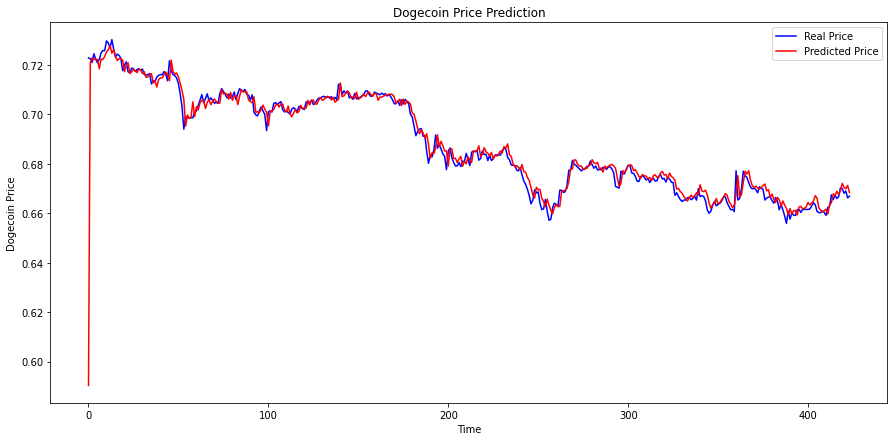

In [ ]:
rmse = np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))

print(f"RMSE = {rmse}")

plt.figure(figsize= (15,7))
plt.plot(real_stock_price, color = 'blue', label = "Real Price")
plt.plot(predicted_stock_price, color = 'red', label = "Predicted Price")
plt.title("Dogecoin Price Prediction")
plt.xlabel("Time")
plt.ylabel("Dogecoin Price")
plt.legend()

plt.show()

# Notes on different model performances

In [ ]:
eval_dict = {"optimizer": ["adam","adam","adam","adam","adam","adam","adam","adam","adam", "adam", "rmsprop", "rmsprop", "adam"],
             "loss": ["mse","mse","mse","mse","mse","mse","mse","mse","mse", "mse", "mse", "mse", "mse"],
              "history_size": [14, 14, 3, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2],
             "epochs": [500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500],
             "layer0": [50,50,50,50,50,50, 50, 50, 50, 50, 50, 100, 100],
            "layer1": [10, 20, 20, 20, 50, 50, 0, 50, 20, 20, 50, 10, 10],
           "layer2": [10, 10, 10, 20, 10, 10, 0, 50, 0, 10, 10, 0, 0],
           "layer3": [0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           "layer4": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           "layer5": [0, 0, 0, 0, 0, 0,0, 0, 0, 0, 0, 0, 0],
            "output": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
             "batch_size": [32,32,32,32,32,32,32,32,32,32,32,32,32],
           "rmse": [0.051, 0.037, 0.017, 0.018, 0.014, 0.021, 0.020, 0.023, np.NaN, 0.023, np.NaN, 0.020, 0.022]}

eval_df = pd.DataFrame.from_dict(eval_dict)

#for k,v in eval_dict.items():
  #print(f"{k} : {len(v)}")

eval_df

,optimizer,loss,history_size,epochs,layer0,layer1,layer2,layer3,layer4,layer5,output,batch_size,rmse
0,adam,mse,14,500,50,10,10,0,0,0,1,32,0.051
1,adam,mse,14,500,50,20,10,0,0,0,1,32,0.037
2,adam,mse,3,500,50,20,10,0,0,0,1,32,0.017
3,adam,mse,3,500,50,20,20,10,0,0,1,32,0.018
4,adam,mse,2,500,50,50,10,0,0,0,1,32,0.014
5,adam,mse,1,500,50,50,10,0,0,0,1,32,0.021
6,adam,mse,2,500,50,0,0,0,0,0,1,32,0.020
7,adam,mse,2,500,50,50,50,0,0,0,1,32,0.023
8,adam,mse,2,500,50,20,0,0,0,0,1,32,NaN
9,adam,mse,2,500,50,20,10,0,0,0,1,32,0.023


In [ ]:
df_final.head()

,price,Google_Trends
2021-08-28 00:00:00,-1.390250,-1.0
2021-08-28 01:00:00,-1.373264,-1.0
2021-08-28 02:00:00,-1.384719,-1.0
2021-08-28 03:00:00,-1.394196,-1.0
2021-08-28 04:00:00,-1.396323,-1.0


In [ ]:
df_pred = pd.DataFrame(X_test[0], columns= ["high", "Google_trends"])
df_pred

,high,Google_trends
0,0.623125,0.722772
1,0.640528,0.693069
2,0.651518,0.623762
3,0.647062,0.574257
4,0.648080,1.000000
5,0.750242,0.841584
6,0.772567,0.841584
7,0.733399,0.663366
8,0.718805,0.683168
9,0.714355,0.673267


In [ ]:
def preprocess(df, scaler):
    """method that pre-process the data"""

    # log transforming the data
    df["high"] = np.log(df["high"])

    # selecting relevant column from df
    dataset = df.values

    # scaling the data
    dataset_scaled = scaler.fit_transform(dataset)

    dataset_scaled = dataset_scaled.reshape(1,dataset.shape[0],dataset.shape[1])

    return dataset_scaled, scaler


def inverse_scaler(pred, scaler):

  pred = inverse_transformer(pred)

  pred = np.exp(pred)

  return pred

In [ ]:
df_pred_preproc, scaler = preprocess(df_pred, scaler)

In [ ]:
pred = model.predict(df_pred_preproc)
prediction = inverse_scaler(pred, scaler)[0][0]

prediction

IndexError: ignored

In [ ]:
df_pred_preproc.shape

In [ ]:
pred = model.predict(df_pred_preproc)[0][0]
pred

# Features

- historical price data
- google price data
- rendite (calculate daily return)
- kumulierte rendite (z.b. letzte 5 Tage)
- short term moving average (letzte 10 Tage)
- long term moving average (letzte 30 Tage)
- alternativ: binäres feature (liegt kurzfristiger MA über langfristigen MA)
- talib (financial indicators inkludieren)
- talib RSI (relative strength index)
- volumen inkludieren

- evtl. auf Klassifikationsproblem umsteigen